In [ ]:
# ================================================================
# PURPOSE
# ------------------------------------------------
# Parameter-sweep helpers for a Qiskit Aer density-matrix sandbox.
#
# Adds:
#  • build_noise_model_no_rz_with_delay(...)
#      - No T1/T2 on virtual 'rz' (only 'id','sx','x')
#      - T1/T2 applied to explicit 'delay' instructions
#      - Optional 2q noise (relaxation ∘ depolarizing) on 'cx'
#  • sweep_idle_time_plus(...)
#      - Prepare |+>, sweep idle (delay) time, plot purity & fidelity vs idle
#  • sweep_cx_gate_time_bell(...)
#      - Prepare Bell, sweep CX duration, plot purity & fidelity vs CX time
#
# Assumes these exist elsewhere in your notebook:
#  • run_and_get_dm(circ, simulator): returns final density matrix (np.ndarray)
#  • sim_dm_clean = AerSimulator(method="density_matrix")  # noiseless
#  • purity(rho): Tr(rho^2)
#
# Notes:
#  • run_and_get_dm should transpile with scheduling so delay(...) survives.
#  • Matplotlib is used for quick plots.
# ================================================================


In [7]:
# ====== Cell 1: Purpose banner & imports for the sweep helpers ======

# Purpose:
# Provide helpers to (a) build a physically-faithful noise model (no T1/T2 on virtual RZ,
# relaxation on explicit delay ops, optional 2q noise on CX), and
# (b) sweep idle time (|+>) or CX time (Bell) and plot fidelity/purity.

import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, state_fidelity
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    depolarizing_error,
    thermal_relaxation_error,
)


In [8]:
# ====== Cell 2: Build a NoiseModel (no T1/T2 on RZ, relaxation on 'delay') ======

def build_noise_model_no_rz_with_delay(
    T1, T2,                 # coherence times (seconds)
    gate_time_1q,           # typical 1q gate duration (seconds)
    p1,                     # depolarizing probability per 1q gate
    include_cx=True,        # whether to model 2q noise
    gate_time_2q=250e-9,    # CX duration (seconds) — usually >> 1q times
    p2=0.02,                # depolarizing probability per CX
    t_idle=0.0              # duration (seconds) of explicit delay(...) in your circuit
):
    """
    Returns a Qiskit NoiseModel that reflects:
      - T1/T2 + depolarizing on *physical* 1q ops only ('id','sx','x'); NOT on 'rz'.
      - Thermal relaxation attached to 'delay' with duration t_idle (so idle decoheres).
      - Optional 2q noise on 'cx' (relaxation on both qubits + depolarizing).
    """
    nm = NoiseModel()  # container for per-instruction errors

    # ---- One-qubit ops: apply errors to 'id','sx','x' (exclude 'rz', which is virtual) ----
    oneq_ops = ["id", "sx", "x"]                      # 'rz' intentionally omitted
    depol_1q = depolarizing_error(p1, 1)              # isotropic Pauli mixing
    therm_1q = thermal_relaxation_error(T1, T2, gate_time_1q)  # T1/T2 over 1q duration

    # Compose: equivalent to applying depolarizing then T1/T2 for that instruction
    nm.add_all_qubit_quantum_error(therm_1q.compose(depol_1q), oneq_ops)

    # ---- Explicit idle relaxation: attach T1/T2 to 'delay' instruction of length t_idle ----
    if t_idle and t_idle > 0:
        therm_idle = thermal_relaxation_error(T1, T2, t_idle)
        nm.add_all_qubit_quantum_error(therm_idle, ["delay"])

    # ---- Optional two-qubit noise on CX ----
    if include_cx:
        depol_2q = depolarizing_error(p2, 2)          # 2q depolarizing
        # T1/T2 acting on BOTH qubits during the whole CX window
        therm_2q = thermal_relaxation_error(T1, T2, gate_time_2q).tensor(
            thermal_relaxation_error(T1, T2, gate_time_2q)
        )
        nm.add_all_qubit_quantum_error(therm_2q.compose(depol_2q), ["cx"])

    return nm


In [10]:
# ====== Cell 3: Sweep idle time for |+> (fidelity & purity vs idle) ======

def sweep_idle_time_plus(
    idle_ns_list,                 # list of idle durations in ns, e.g., [0, 50, 100, ...]
    T1=50e-6, T2=40e-6,           # coherence times (seconds)
    gate_time_1q=35e-9,           # 1q gate duration (seconds)
    p1=0.01,                      # depolarizing prob per 1q gate
    include_cx=False              # unused here; kept for API symmetry
):
    """
    Prepare |+>, insert an explicit delay(t_idle), simulate, and report:
      (t_idle_ns, Tr(ρ²), Fidelity_to_ideal_|+>).
    Longer idles => more T1/T2 exposure => lower purity and fidelity.
    """
    results = []  # collect (idle_ns, purity, fidelity)

    # -- Base circuit: |0> --H--> |+> (we'll copy this and add delay per sweep point)
    base = QuantumCircuit(1, name="H_plus_with_idle")
    base.h(0)

    for t_ns in idle_ns_list:
        # Convert ns -> s for noise model; keep ns for circuit.delay (which uses integer ns)
        t_idle = float(t_ns) * 1e-9

        # Build a fresh noise model *matching this idle duration* on 'delay'
        nm = build_noise_model_no_rz_with_delay(
            T1=T1, T2=T2, gate_time_1q=gate_time_1q, p1=p1,
            include_cx=include_cx,  # no effect in 1q test, but harmless
            t_idle=t_idle
        )
        sim_noisy = AerSimulator(method="density_matrix", noise_model=nm)

        # Copy circuit and insert a delay of exactly t_ns nanoseconds (only if >0)
        qc = base.copy()
        if t_idle > 0:
            qc.delay(int(round(t_ns)), 0, unit="ns")

        # Reference (noiseless) density matrix for *this* circuit shape (with/without delay)
        rho_ref = run_and_get_dm(qc, sim_dm_clean)

        # Noisy density matrix under the built noise model
        rho_noi = run_and_get_dm(qc, sim_noisy)

        # Metrics: purity and fidelity to the ideal ρ_ref
        P = purity(rho_noi)
        F = state_fidelity(DensityMatrix(rho_ref), DensityMatrix(rho_noi))
        results.append((t_ns, P, F))

    # ---- Plot fidelity vs idle ----
    x = [r[0] for r in results]     # idle times (ns)
    F_list = [r[2] for r in results]
    plt.figure()
    plt.plot(x, F_list, marker="o", label="Fidelity to |+⟩")
    plt.xlabel("Idle time (ns)")
    plt.ylabel("Fidelity")
    plt.title("|+⟩ fidelity vs idle time")
    plt.legend()
    plt.show()

    # ---- Plot purity vs idle ----
    P_list = [r[1] for r in results]
    plt.figure()
    plt.plot(x, P_list, marker="s", label="Purity Tr(ρ²)")
    plt.xlabel("Idle time (ns)")
    plt.ylabel("Purity")
    plt.title("|+⟩ purity vs idle time")
    plt.legend()
    plt.show()

    # ---- Console summary ----
    print("\nIdle sweep (|+⟩):")
    for t_ns, P, F in results:
        print(f"  t_idle = {t_ns:>6.1f} ns  |  Purity = {P:.6f}  |  Fidelity = {F:.6f}")

    return results


In [11]:
# ====== Cell 4: Sweep CX gate time for Bell (fidelity & purity vs CX duration) ======

def sweep_cx_gate_time_bell(
    cx_ns_list,                    # list of CX durations in ns, e.g., [150, 200, ...]
    T1=50e-6, T2=40e-6,            # coherence times (seconds)
    gate_time_1q=35e-9,            # 1q gate duration (seconds)
    p1=0.01,                       # depolarizing prob per 1q gate
    p2=0.02,                       # depolarizing prob per CX gate
    t_idle_ns_before_cx=0.0        # optional idle (ns) *before* CX on both qubits
):
    """
    Prepare a Bell state with optional idle before CX, then sweep the CX duration.
    Return (cx_ns, Tr(ρ²), Fidelity_to_ideal_Bell).
    Longer CX => more relaxation/dephasing during entanglement => lower fidelity/purity.
    """
    results = []  # collect (cx_ns, purity, fidelity)

    # -- Build the Bell "skeleton": H on qubit 0, optional delays, then CX --
    base = QuantumCircuit(2, name="bell_idle_before_cx")
    base.h(0)
    if t_idle_ns_before_cx and t_idle_ns_before_cx > 0:
        # Insert the same idle on both qubits to expose pre-CX decay fairly
        base.delay(int(round(t_idle_ns_before_cx)), 0, unit="ns")
        base.delay(int(round(t_idle_ns_before_cx)), 1, unit="ns")
    base.cx(0, 1)

    # Compute the *ideal* reference density matrix for this exact circuit structure
    rho_ref = run_and_get_dm(base, sim_dm_clean)

    for tau_ns in cx_ns_list:
        tau_2q = float(tau_ns) * 1e-9  # ns -> s

        # Build a noise model using this specific CX duration (2q T1/T2 + depol)
        nm = build_noise_model_no_rz_with_delay(
            T1=T1, T2=T2, gate_time_1q=gate_time_1q, p1=p1,
            include_cx=True, gate_time_2q=tau_2q, p2=p2,
            t_idle=(float(t_idle_ns_before_cx)*1e-9 if t_idle_ns_before_cx else 0.0)
        )
        sim_noisy = AerSimulator(method="density_matrix", noise_model=nm)

        # Simulate noisy Bell and compute metrics vs ideal reference
        rho_noi = run_and_get_dm(base, sim_noisy)
        P = purity(rho_noi)  # global purity Tr(ρ²)
        F = state_fidelity(DensityMatrix(rho_ref), DensityMatrix(rho_noi))
        results.append((tau_ns, P, F))

    # ---- Plot fidelity vs CX duration ----
    x = [r[0] for r in results]     # CX times (ns)
    F_list = [r[2] for r in results]
    plt.figure()
    plt.plot(x, F_list, marker="o", label="Bell fidelity to |Φ⁺⟩")
    plt.xlabel("CX gate time (ns)")
    plt.ylabel("Fidelity")
    plt.title("Bell fidelity vs CX gate time")
    plt.legend()
    plt.show()

    # ---- Plot purity vs CX duration ----
    P_list = [r[1] for r in results]
    plt.figure()
    plt.plot(x, P_list, marker="s", label="Global purity Tr(ρ²)")
    plt.xlabel("CX gate time (ns)")
    plt.ylabel("Purity")
    plt.title("Bell purity vs CX gate time")
    plt.legend()
    plt.show()

    # ---- Console summary ----
    print("\nCX-time sweep (Bell):")
    for tau_ns, P, F in results:
        print(f"  τ_CX = {tau_ns:>6.1f} ns  |  Purity = {P:.6f}  |  Fidelity = {F:.6f}")

    return results


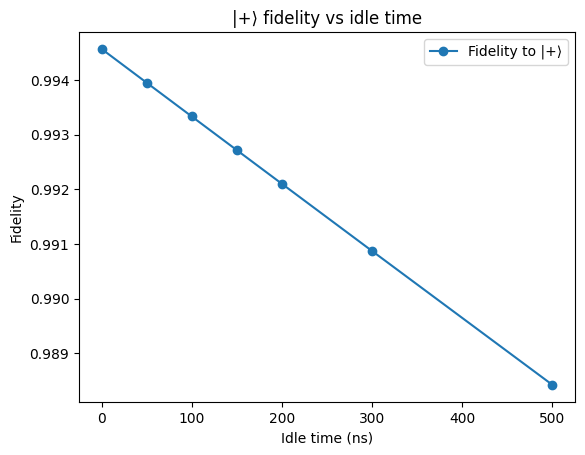

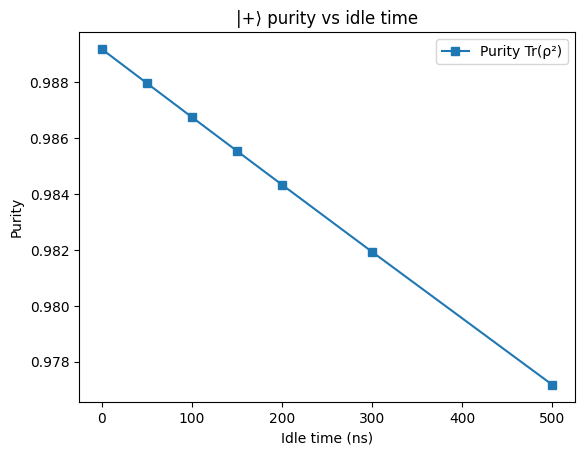


Idle sweep (|+⟩):
  t_idle =    0.0 ns  |  Purity = 0.989193  |  Fidelity = 0.994567
  t_idle =   50.0 ns  |  Purity = 0.987973  |  Fidelity = 0.993949
  t_idle =  100.0 ns  |  Purity = 0.986757  |  Fidelity = 0.993332
  t_idle =  150.0 ns  |  Purity = 0.985545  |  Fidelity = 0.992716
  t_idle =  200.0 ns  |  Purity = 0.984337  |  Fidelity = 0.992100
  t_idle =  300.0 ns  |  Purity = 0.981932  |  Fidelity = 0.990872
  t_idle =  500.0 ns  |  Purity = 0.977172  |  Fidelity = 0.988423


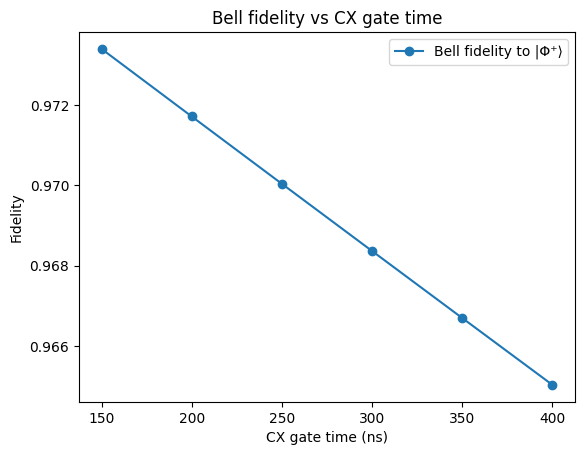

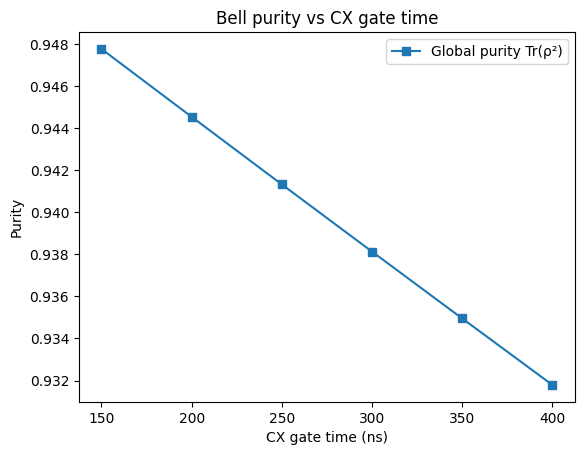


CX-time sweep (Bell):
  τ_CX =  150.0 ns  |  Purity = 0.947781  |  Fidelity = 0.973394
  τ_CX =  200.0 ns  |  Purity = 0.944549  |  Fidelity = 0.971712
  τ_CX =  250.0 ns  |  Purity = 0.941334  |  Fidelity = 0.970035
  τ_CX =  300.0 ns  |  Purity = 0.938136  |  Fidelity = 0.968362
  τ_CX =  350.0 ns  |  Purity = 0.934955  |  Fidelity = 0.966693
  τ_CX =  400.0 ns  |  Purity = 0.931791  |  Fidelity = 0.965029


In [13]:
# ====== Cell 5: Example drivers to run the sweeps ======

# Example A: Sweep idle time for |+> (keep device/gate params consistent with earlier cells)
idle_list_ns = [0, 50, 100, 150, 200, 300, 500]
plus_results = sweep_idle_time_plus(
    idle_list_ns,
    T1=50e-6,            # 50 µs
    T2=40e-6,            # 40 µs
    gate_time_1q=35e-9,  # 35 ns 1q gate
    p1=0.01              # 1% depolarizing per 1q gate
)

# Example B: Sweep CX time for Bell (add a fixed 100 ns idle before CX to expose pre-gate decay)
cx_list_ns = [150, 200, 250, 300, 350, 400]
bell_results = sweep_cx_gate_time_bell(
    cx_list_ns,
    T1=50e-6,            # 50 µs
    T2=40e-6,            # 40 µs
    gate_time_1q=35e-9,  # 35 ns
    p1=0.01,             # 1% 1q depol
    p2=0.02,             # 2% 2q depol
    t_idle_ns_before_cx=100.0  # 100 ns idle on both qubits before CX
)
